In [19]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def extract_features(file_path, segment_duration=0.1, sr=22050, visualize=True):
    y, sr = librosa.load(file_path, sr=sr)
    features_list = []

    segment_length = int(segment_duration * sr)
    num_segments = int(np.floor(len(y) / segment_length))

    times = []
    pitch_means = []
    centroids = []
    rms_energies = []

    for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length
        segment = y[start:end]

        duration = librosa.get_duration(y=segment, sr=sr)

        # Pitch extraction (with frame_length and hop_length parameters)
        f0, voiced_flag, voiced_probs = librosa.pyin(
            segment,
            fmin=librosa.note_to_hz('C2'),
            fmax=librosa.note_to_hz('C7'),
            frame_length=segment_length  # Important for short segments
        )
        # Handle case where no pitch is detected
        pitch_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0

        # Spectral Centroid
        centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)[0]
        centroid_mean = np.mean(centroid)

        # RMS Energy - use the first element since librosa.feature.rms returns 2D array
        rms = librosa.feature.rms(y=segment, frame_length=segment_length, hop_length=segment_length)[0]
        rms_mean = np.mean(rms)

        # Store mid-time for plotting
        mid_time = (start + end) / 2 / sr
        times.append(mid_time)
        pitch_means.append(pitch_mean)
        centroids.append(centroid_mean)
        rms_energies.append(rms_mean)
        
        features_list.append({
            'Segment': i,
            'Duration': duration,
            'PitchMean': pitch_mean,
            'Centroid': centroid_mean,
            'RMS': rms_mean
        })

    if visualize:
        plt.figure(figsize=(14, 8))
        
        # Create subplots since the scales are very different
        ax1 = plt.subplot(311)
        ax1.plot(times, pitch_means, label='Pitch Mean (Hz)', color='b', marker='o')
        ax1.set_ylabel('Pitch (Hz)')
        ax1.grid(True)
        
        ax2 = plt.subplot(312, sharex=ax1)
        ax2.plot(times, centroids, label='Spectral Centroid (Hz)', color='g', marker='s')
        ax2.set_ylabel('Centroid (Hz)')
        ax2.grid(True)
        
        ax3 = plt.subplot(313, sharex=ax1)
        ax3.plot(times, rms_energies, label='RMS Energy', color='r', marker='^')
        ax3.set_ylabel('RMS Energy')
        ax3.set_xlabel('Time (s)')
        ax3.grid(True)
        
        plt.suptitle('Audio Feature Trends Over Time')
        plt.tight_layout()
        plt.show()

    return features_list

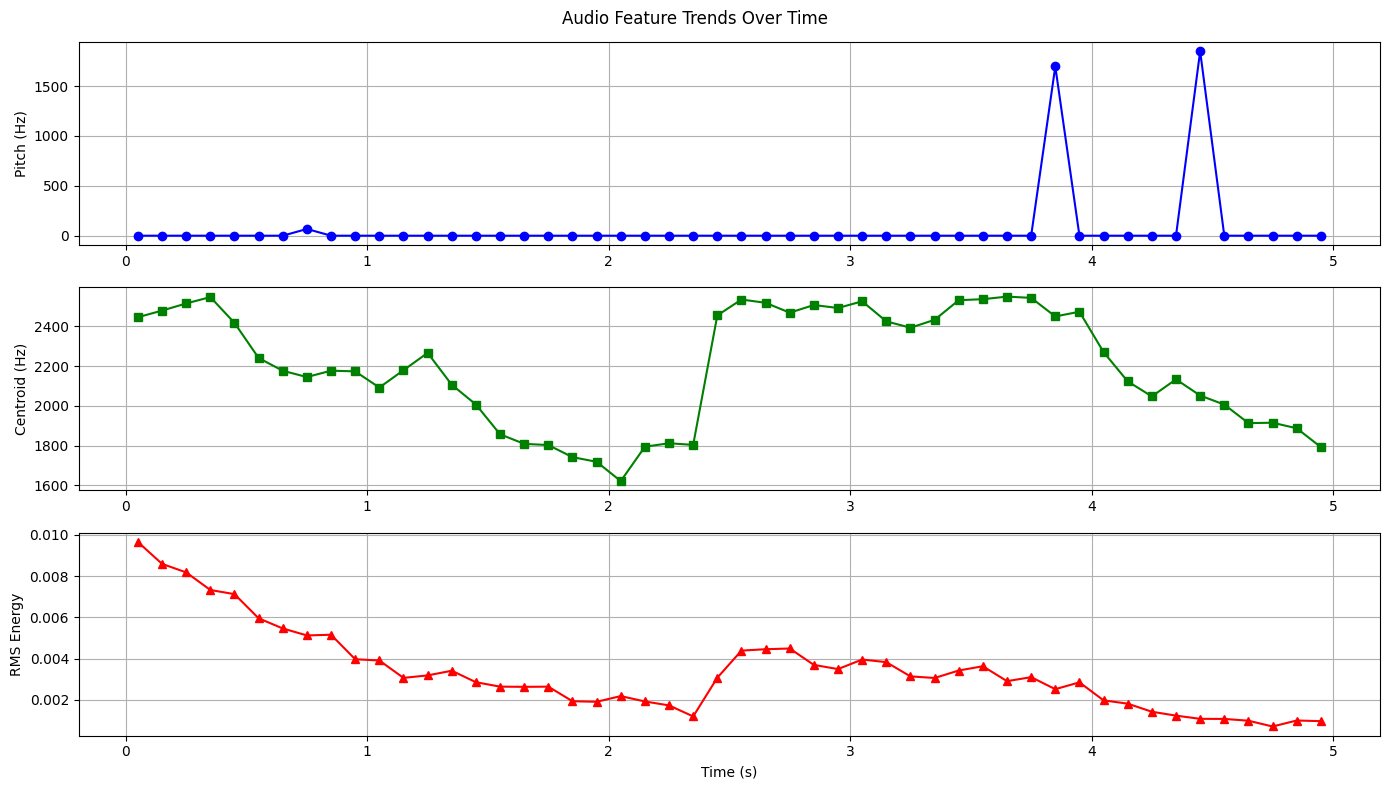

In [28]:
file_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data\5-261464-A-23.wav"
features = extract_features(file_path)

# Print the features
# for f in features:
#     print(f)

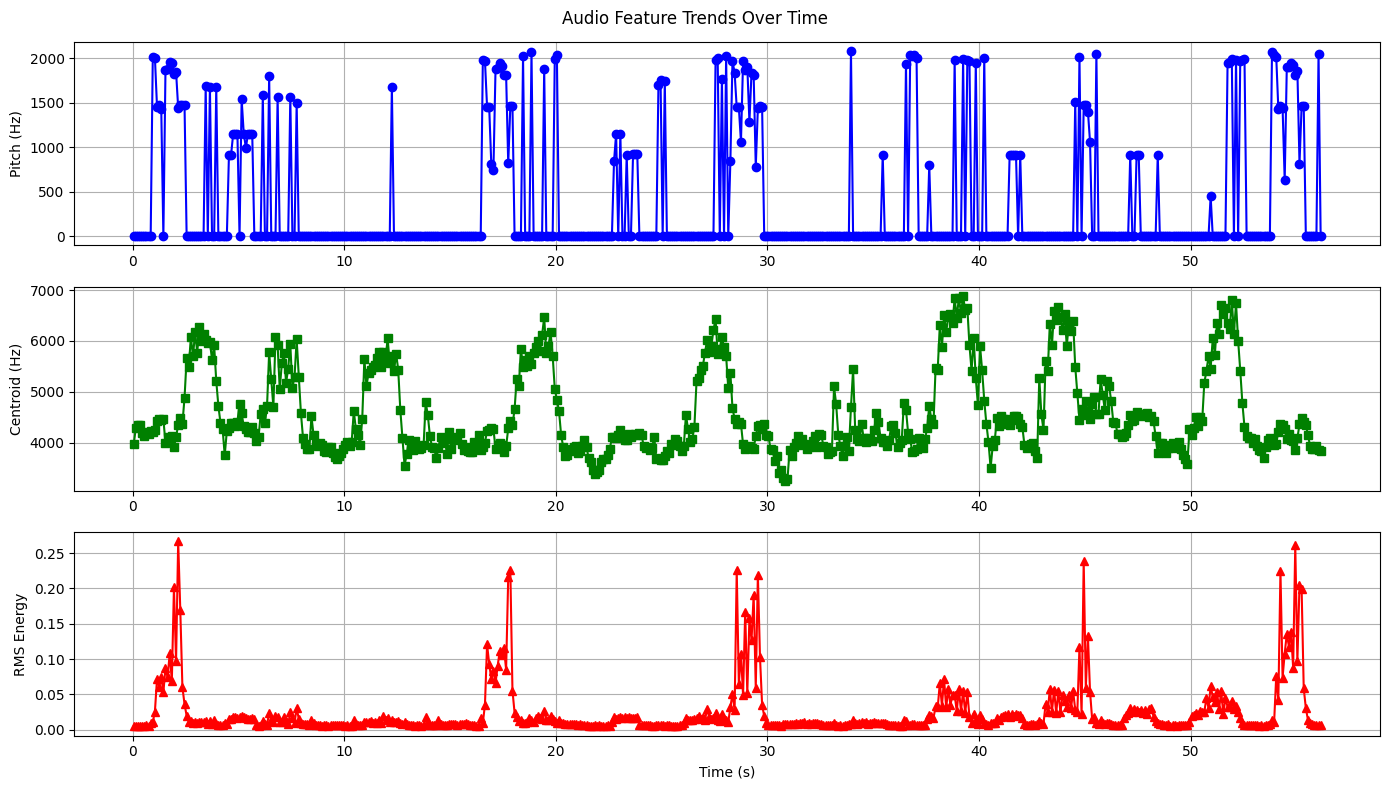

In [29]:
file_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto\207856.mp3"
features = extract_features(file_path)